In [ ]:
# Installing Python libraries
!pip install pymongo==3.7.2 folium==0.9.1 geopandas==0.7.0 seaborn numpy tqdm

In [91]:
import pymongo                            # Library to access MongoDB
from pymongo import MongoClient           # Imports MongoClient 
import pandas as pd                       # Library to work with dataframes
import folium                             # Library to create the map
from folium import plugins                # plugin to create a heatmap
import seaborn as sns
import numpy as np
from tqdm import tqdm

In [24]:
# uri (uniform resource identifier) defines the connection parameters 
uri = 'mongodb://127.0.0.1:27017'
# start client to connect to MongoDB server 
client = MongoClient( uri )

In [ ]:
def standardize_issue_name(name):
    """Try to standardize issue types so they can be shown in less columns,
    """
    return name.replace(' ', '').replace('-', '').lower()

def find_comments_per_issue():
    """This function runs a count query per issue type on each collection in our Jira database. It might take a minute or so.
    
    TODO: filter comments by toxic words (hopefully i can just edit the mongodb query to accept a list)
    
    """
    data = []
    
    collections = db.list_collection_names()
    # collections = np.array(db.list_collection_names())[:2]
    
    # Create progress bar so we can see what it is doing.
    progress_bar = tqdm(collections)
    for name in progress_bar:
        progress_bar.set_description("Processing %s" % name)
        result = list(db[name].aggregate([
            { "$group": { "_id": '$fields.issuetype.name', "count": {"$sum": 1} } },
        ]))
        subdata = {};
        # Add any issue types with count data to the subdata.
        for row in result:
            subdata[standardize_issue_name(row['_id'])] = row['count']
        data.append([name, subdata])
    
    # Extract issue types
    issue_types = set()
    for row in data:
        for key in row[1].keys():
            issue_types.add(key)
            
    # Fill in the complete matrix because issue types differ per subset.
    data2 = [] 
    for row in data:
        # First column = name
        subdata = [row[0]]
        for issue_type in issue_types:
            subdata.append(row[1][issue_type] if issue_type in row[1] else 0)
        data2.append(subdata)

    data2 = np.array(data2)
    # # Use first column as index, rest as the data.
    df = pd.DataFrame(np.array(data2[:,1:], dtype=np.int32), columns=list(issue_types), index=data2[:,0])   
    return df

df = find_comments_per_issue()

,wish,newproject,devsubtask,subrequirement,gitboxrequest,blognewblogrequest,newtlp,ithelp,production/pilotdata,qualityrisk,...,backport,temp,componentupgrade,appincident,choosefrombelow...,umbrella,questions,defect,rfe,docui
SecondLife,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,975,0,0
IntelDAOS,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Mojang,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
MariaDB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Hyperledger,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sonatype,0,65487,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Sakai,0,0,0,0,0,0,0,0,370,0,...,0,0,0,0,0,0,0,0,0,0
Qt,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
JFrog,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Spring,0,0,0,0,0,0,0,0,0,0,...,66,0,0,0,0,0,0,305,0,0


['wish', 'newproject', 'devsubtask', 'subrequirement', 'gitboxrequest', 'blognewblogrequest', 'newtlp', 'ithelp', 'production/pilotdata', 'qualityrisk', 'devtask', 'pruning', 'designrequest', 'businessrequirement', 'design', 'suitablenamesearch', 'tracker', 'incident', 'publishingsupport', 'ctschallenge', 'test', 'task', 'svn>gitmigration', 'supportpatch', 'improvement', 'risk', 'request', 'blogsaccesstoexistingblog', 'setupticket', 'technicalrequirement', 'marketproblem', 'testtask', 'spike', 'productionissue', 'developmenttask', 'svn>gitmirroring', 'project', '(deprecated)contributedpatch', 'blogsnewbloguseraccountrequest', 'question', 'branch', 'paymentsupport', 'refactoring', 'rtc', 'qetask', 'proposal', 'outage', 'publicsecurityvulnerability', 'changerequest', 'a/btest', 'successmetric', 'supportticket', 'access', 'qesubtask', 'newjiraproject', 'epic', 'pricingchange', 'thirdpartyissue', 'simplesubtask', 'infrastructure', 'documentation', 'pendingreview', 'purchase', 'idea/feature

<AxesSubplot: >

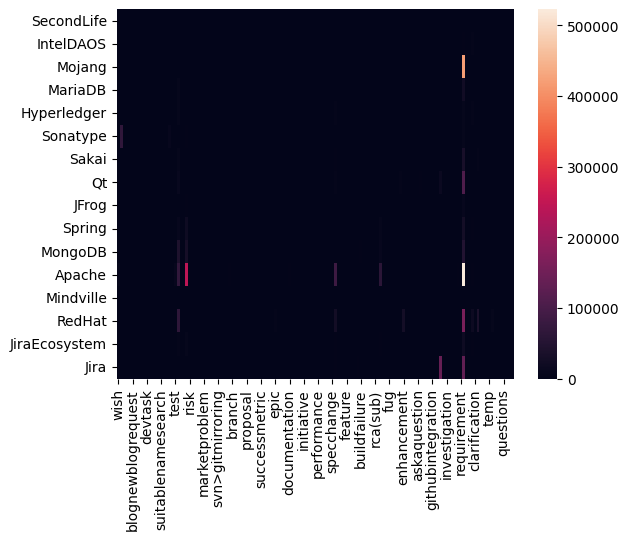

In [119]:
display(df)
print(list(df.columns))
sns.heatmap(df)